# Hackathon Sentiment Analysis: Post October 7th Conflict

## 1. Problem Statement

Following the October 7th attacks in Israel and the ensuing war in Gaza, there was a noticeable increase in public discourse and animosity directed toward Israelis and the State of Israel.

Given the subsequent events—including pressure on international organizations (like Eurovision), the threat of ICC arrest warrants, and the ICJ case—our objective is to analyze whether the October 7th war and its aftermath significantly **impacted public sentiment towards Israel** across different time periods on social media.

## 2. Data Collection and Feature Selection

### 2.1 Data Scope and Sources

| Data Needed | Sources | Disclaimer |
| ----- | ----- | ----- |
| Date of Comment (`Created`) | Reddit (Primary Source) | API restrictions (Twitter's limited free usage) prevented us from collecting data from Twitter and gathering more customized data (e.g., `region`). |
| Subreddit | Reddit | \- |
| Comment Text (`Body`) | Reddit | \- |
| Comment Score (`Score`) | Reddit | \- |

### 2.2 Data Collection Process

We extracted comments from the **"worldnews"** subreddit using an external tool. We sampled the first **1,000 comments** for each time period that contained one of the following keywords: **"israel," "idf,"** or **"netanyahu."**

**Time Periods for Analysis:**

| Period Name | Start Date | End Date | Duration |
| ----- | ----- | ----- | ----- |
| **Before** | 2023-09-21 | 2023-10-06 | Pre-event Baseline |
| **During** | 2023-10-07 | 2023-10-10 | Immediate Impact |
| **After** | 2024-04-07 | 2024-04-21 | Long-term Trend (Due to large file sizes, the "After" period was sampled several months later.) |

### 2.3 Feature Selection

1. ***Created (Date)***: Used to group the data into the defined time periods for comparative analysis.

2. ***Body (Comment Text)***: The primary feature used to calculate the sentiment score.

3. ***Score***: The Reddit user-driven rating (Upvotes - Downvotes). We will analyze the correlation between this feature and the calculated sentiment score.

## 3. Model Choice: VADER Sentiment Analysis

### 3.1 Model Rationale

We selected **VADER (Valence Aware Dictionary and Sentiment Reasoner)**, a fast and robust **lexicon-based** model, specifically because it was designed and validated for use with social media text.

### 3.2 VADER Mechanism (How it Works)

VADER determines sentiment based on two primary components: a static word list and a set of linguistic rules:

#### A. Lexicon (Dictionary)
* Each word has an associated sentiment score (polarity), derived from human-rated consensus (e.g., 'happy' $\rightarrow +2.5$, 'terrible' $\rightarrow -3.2$).

#### B. Linguistic Rules (Syntactical Features)
The model applies grammatical and syntactical rules to modify the scores from the lexicon, ensuring it adapts to informal language conventions:

1.  **Punctuation:** Using multiple exclamation marks (e.g., "amazing!!!") increases the intensity.
2.  **Capitalization:** All caps (e.g., "AWESOME") increases intensity.
3.  **Degree Modifiers/Adverbs:** Words like "extremely" or "barely" amplify or diminish the subsequent word's score.
4.  **Negation:** Using words like "not" (e.g., "not good") reverses the polarity of the following term.

### 3.3 Model Output and Interpretation

VADER produces four distinct metrics for each comment:

| Output Score | Description |
| ----- | ----- |
| **Negative (neg)** | The proportion of the text's words that contribute to the negative sentiment lexicon. |
| **Neutral (neu)** | The proportion of the text's words that contribute to the neutral sentiment lexicon. |
| **Positive (pos)** | The proportion of the text's words that contribute to the positive sentiment lexicon. |
| **Compound (compound)** | The **normalized, weighted composite score** that summarizes the overall sentiment of the text. This is our primary metric. |

The **Compound Score** is calculated by summing the modified scores of all relevant words and normalizing the total to fall between $-1$ **(most extreme negative)** and $+1$ **(most extreme positive)**.

**Thresholds for Categorization:**

* **Positive Sentiment:** Compound score $\ge 0.05$

* **Neutral Sentiment:** $\mathbf{-0.05 < \text{Compound score} < 0.05}$

* **Negative Sentiment:** Compound score $\le -0.05$

### 3.4 Advantages and Limitations

VADER's design as a fast, lexicon-based tool presents a clear trade-off between efficiency and deep contextual understanding.

#### Advantages (Why it is Ideal for Social Media)

VADER excels in this domain due to its speed and targeted focus on informal language:

1.  **Speed and Efficiency:** It does not rely on complex neural networks, making it extremely fast for processing massive volumes of social media posts on standard hardware (No training or GPUs required).
2.  **Social Media Lexicon:** It was specifically developed and validated using social media texts, giving it high accuracy in handling internet slang, emojis, and emoticons.
3.  **Rule-Based Strength:** Its explicit rules for capitalization, punctuation, and degree modifiers perfectly model how intensity is conveyed in short, digital messages.
4.  **Ease of Interpretation:** The Compound Score output is simple and clear, making results easy for analysts to interpret and explain.

#### Limitations (The Trade-Off)

Its lexicon-based nature introduces specific weaknesses compared to deep learning models:

1.  **Sarcasm and Nuance:** Being rule-based, it may not perfectly capture complex human sarcasm, irony, or highly nuanced language that relies on deep conversational context.
2.  **Lack of Contextual Understanding:** It is not able to understand the deep context or the sequential relationship between words (e.g., how the meaning of a sentence is changed by a phrase that appears much later).

## Data Collection & Initial Exploration

In [29]:
import pandas as pd

# Load json files as DataFrames for different time ranges
df_before = pd.read_json('comments_before_oct7.jsonl', lines=True)
df_during = pd.read_json('comments_during_oct7.jsonl', lines=True)
df_after = pd.read_json('comments_after_oct7.jsonl', lines=True)

# Concatenate all data into one DataFrame
df = pd.concat([df_before, df_during, df_after], ignore_index=True)

In [30]:
# Basic Exploration of the DataFrame

print("Shape:", df.shape)
print("="*25)
print(f"\n{df.head()}")
print("="*25)
print(f"\n{df.info()}")

Shape: (3000, 72)

                              _meta all_awardings  approved_at_utc  \
0  {'retrieved_2nd_on': 1703275026}            []              NaN   
1  {'retrieved_2nd_on': 1703275262}            []              NaN   
2  {'retrieved_2nd_on': 1703275301}            []              NaN   
3  {'retrieved_2nd_on': 1703275934}            []              NaN   
4  {'retrieved_2nd_on': 1703276762}            []              NaN   

   approved_by  archived  associated_award              author  \
0          NaN     False               NaN          chrisjinna   
1          NaN     False               NaN       ToastedPerson   
2          NaN     False               NaN        bobdob123usa   
3          NaN     False               NaN       FYoCouchEddie   
4          NaN     False               NaN  preemptivePacifist   

  author_flair_background_color  author_flair_css_class author_flair_richtext  \
0                          None                     NaN                    []   
1

## Data Preprocessing

In [31]:
# Leave relevant columns only
df = df[['created', 'body', 'score']]

In [32]:
# Check duplicates
df.duplicated().sum()

np.int64(0)

In [33]:
# Transform created from unix epoch to timestamp

df['created'] = pd.to_datetime(df['created'], unit='s')
df['created']

,created
0,2023-09-22 00:01:57
1,2023-09-22 00:07:52
2,2023-09-22 00:08:53
3,2023-09-22 00:25:11
4,2023-09-22 00:46:38
...,...
2995,2024-04-07 18:01:27
2996,2024-04-07 18:02:04
2997,2024-04-07 18:03:28
2998,2024-04-07 18:03:30


In [34]:
# Create Column to Classify Dates as Before, During, After
start_date = pd.Timestamp('2023-10-07')
end_date = pd.Timestamp('2023-10-21')

df['period'] = df['created'].apply(
    lambda x: 'Before' if x < start_date else
              'During' if start_date <= x <= end_date else
              'After'
)

# Check
df['period'].value_counts()

,count
period,
Before,1000
During,1000
After,1000


In [35]:
# Check statistics
df.describe(include='all')

,created,body,score,period
count,3000,3000,3000.000000,3000
unique,NaN,2980,NaN,3
top,NaN,Yeah no…. Israel has had an issue with raping ...,NaN,Before
freq,NaN,4,NaN,1000
mean,2023-12-03 20:42:22.366666752,NaN,27.805667,NaN
min,2023-09-22 00:01:57,NaN,-347.000000,NaN
25%,2023-09-29 16:08:17.500000,NaN,0.000000,NaN
50%,2023-10-07 07:02:58,NaN,4.000000,NaN
75%,2024-04-07 06:36:11,NaN,19.000000,NaN
max,2024-04-07 18:04:15,NaN,3556.000000,NaN


In [36]:
# Convert all body samples to lowercase
df['body'] = df['body'].str.lower()

## Sentiment Analysis Using VADER

In [37]:
import nltk

# Download the VADER lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [38]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# Instantiate SIA object
sia = SentimentIntensityAnalyzer()

In [39]:
# Run the polarity score on the entire dataset
df['Sentiment_Score'] =  df['body'].apply(lambda x: sia.polarity_scores(x)['compound'])

df.head()

,created,body,score,period,Sentiment_Score
0,2023-09-22 00:01:57,what isn't being occupied right now over there...,-2,Before,-0.3736
1,2023-09-22 00:07:52,"someone needs to grab their sniper, hop on the...",0,Before,-0.1531
2,2023-09-22 00:08:53,> the government of israel is not the same as...,0,Before,0.0000
3,2023-09-22 00:25:11,> israel exploits the holocaust to censor any ...,1,Before,-0.9201
4,2023-09-22 00:46:38,this is not necessarily an extremist view or e...,1,Before,0.3291


#### Correlation Between 'Sentiment_Score' and 'score'

We see that there's no correlation between the features 'score' which represents the number of upvotes - number of downvotes and 'Sentiment_Score' calculated by the VADER model.

From this information we can infer that there's no bias for or against Israel within the worldnews subreddit.

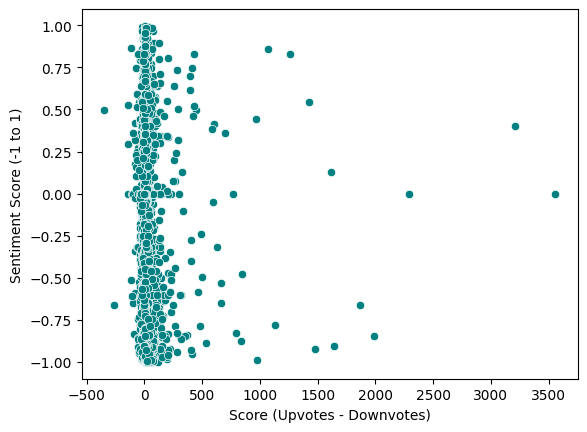

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

df_scores_sentiment = df[~df['score'].isin([0, 1])]

sns.scatterplot(data=df_scores_sentiment, x='score', y='Sentiment_Score', color='teal')
plt.xlabel('Score (Upvotes - Downvotes)')
plt.ylabel('Sentiment Score (-1 to 1)')
plt.show()

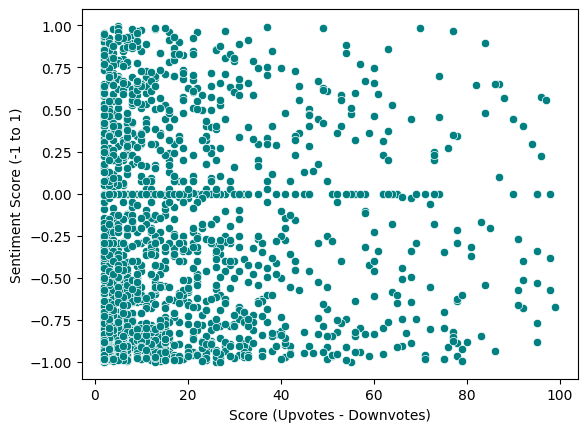

In [41]:
# Comparison of score and sentiment score when score between 0-100
# not including 1 as it's default value when creating a comment

df_score_sentiment_till_100 = df[(df['score'] > 1) & (df['score'] <=100)]

sns.scatterplot(data=df_score_sentiment_till_100, x='score', y='Sentiment_Score', color='teal')
plt.xlabel('Score (Upvotes - Downvotes)')
plt.ylabel('Sentiment Score (-1 to 1)')
plt.show()

In [42]:
# Checking correlation value between upvotes (score) and sentiment score
correlation_value = df['score'].corr(df['Sentiment_Score'])

print(f"The correlation value between 'score' and 'sentiment_score: {correlation_value:.4f}")

The correlation value between 'score' and 'sentiment_score: -0.0046


#### Distribution of Sentiment Score

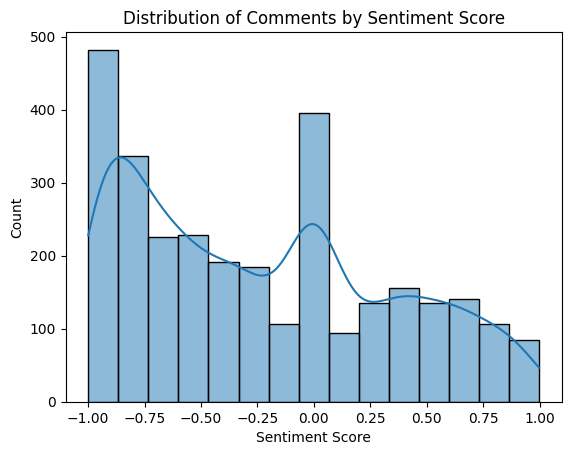

In [43]:
# Overall Distribution of sentiment score
sns.histplot(data=df, x='Sentiment_Score', kde=True)
plt.title('Distribution of Comments by Sentiment Score')
plt.xlabel('Sentiment Score')
plt.show()


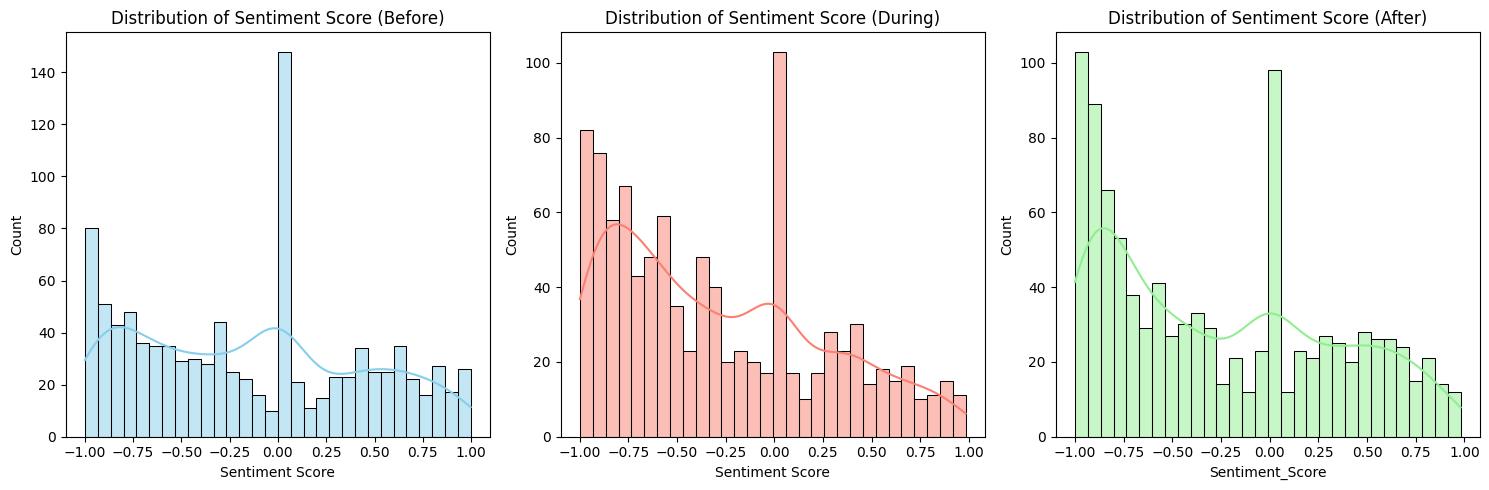

In [44]:
# Distribution of Commments By Time Period
df_before = df[df['period'] == 'Before']
df_during = df[df['period'] == 'During']
df_after = df[df['period'] == 'After']

# Create the figure and 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Distribution of DataFrame 1
sns.histplot(df_before['Sentiment_Score'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Sentiment Score (Before)')
axes[0].set_xlabel('Sentiment Score')


# Plot 2: Distribution of DataFrame 2
sns.histplot(df_during['Sentiment_Score'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Sentiment Score (During)')
axes[1].set_xlabel('Sentiment Score')


# Plot 3: Distribution of DataFrame 3
sns.histplot(df_after['Sentiment_Score'], bins=30, kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title('Distribution of Sentiment Score (After)')


# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout()
plt.show()

#### Average Sentiment Score Across Diferent Periods

/tmp/ipython-input-801994461.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




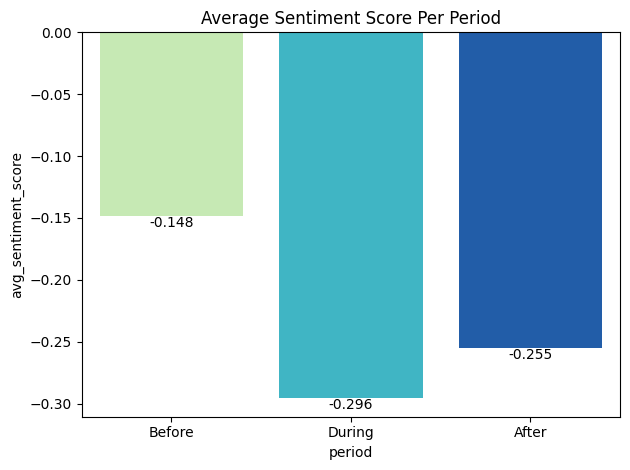

In [45]:
# Avg Sentiment Score before, during and after

# Calculate avg sentiment score per period
period_negative_score = df.groupby('period').agg(
    avg_sentiment_score = ('Sentiment_Score', 'mean')
).reset_index()

# Create Barplot
ax = sns.barplot(data=period_negative_score, x='period', y='avg_sentiment_score', palette='YlGnBu', saturation=1,
              order=['Before', 'During', 'After'])
# Add labels to each bar
for container in ax.containers:
  ax.bar_label(container, fmt='%.3f')
plt.title('Average Sentiment Score Per Period')
plt.tight_layout()
plt.show()

#### Distribution of Upvotes by Lowest Sentiment Score

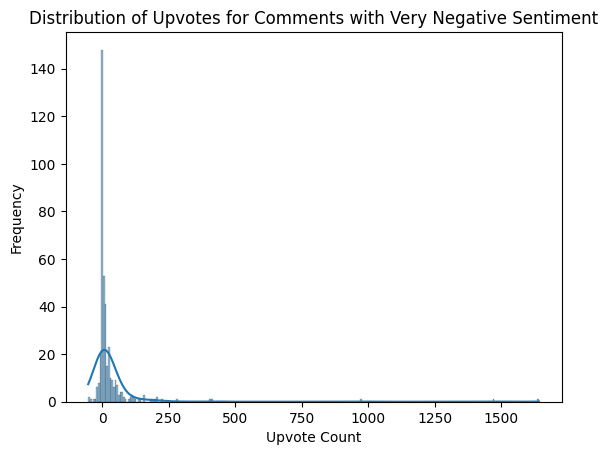

Total Comments: 3000
Very Negative Comments: 402
Proportion: 13.40%


In [46]:
# Distribution of Upvotes by Lowest Sentiment Score
df_negative_sentiment = df[(df['Sentiment_Score'] > -1) & (df['Sentiment_Score'] < -0.9)]
sns.histplot(data=df_negative_sentiment, x='score', kde=True)
plt.title('Distribution of Upvotes for Comments with Very Negative Sentiment')
plt.xlabel('Upvote Count')
plt.ylabel('Frequency')
plt.show()

# Proportion of Comments That Were Very Negative (-0.9 and below)
print(f"Total Comments: {df.shape[0]}\nVery Negative Comments: {df_negative_sentiment.shape[0]}\nProportion: {((df_negative_sentiment.shape[0]/df.shape[0])*100):.2f}%")


#### Top 10 Most Used Keywords Analysis

In [47]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
# Keyword Trend Over Time

from nltk.corpus import stopwords
import re
from collections import Counter


# Load list of English stopwords ('the', 'a', 'is') and convert it to a set
STOPWORDS = set(stopwords.words('english'))

def get_top_keywords(series, top_n=10):
  '''
  Cleans text, removes stopwords, flattens all words, and returns the
  top N most common words.
  '''

  # Break text into words and clean
  # Handles punctuation and splitting comments into words
  all_words = series.astype(str).str.lower().str.findall(r'\b\w+\b').explode()

  additional_words = ['would', 'like', 'they', 'even', 'right', 'https', 'people', 'also', 'going', 'think', 'want']
  # Remove stopwords and filter out short tokens (like single letters)
  filtered_words = all_words[
      ~all_words.isin(STOPWORDS) &
      (all_words.str.len() > 3) &
      ~all_words.isin(additional_words)
  ]

  # Count frequencies
  word_counts = Counter(filtered_words.dropna().tolist())

  # Return the Top N
  return word_counts.most_common(top_n)


# Get top 10 keywords per period
df_top_10_words_before = pd.DataFrame(get_top_keywords(df_before['body']), columns=['Word', 'Count'])
df_top_10_words_during = pd.DataFrame(get_top_keywords(df_during['body']), columns=['Word', 'Count'])
df_top_10_words_after = pd.DataFrame(get_top_keywords(df_after['body']), columns=['Word', 'Count'])



In [49]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with 1 row and 3 columns
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('Before October 7th', 'During October 7th', 'After October 7th')
)

# Plot 1: Before October 7th
fig.add_trace(
    go.Bar(
        x=df_top_10_words_before['Word'],
        y=df_top_10_words_before['Count'],
        marker=dict(color=df_top_10_words_before.index, colorscale='Phase'),
        showlegend=False
    ),
    row=1, col=1
)

# Plot 2: During October 7th
fig.add_trace(
    go.Bar(
        x=df_top_10_words_during['Word'],
        y=df_top_10_words_during['Count'],
        marker=dict(color=df_top_10_words_during.index, colorscale='Phase'),
        showlegend=False
    ),
    row=1, col=2
)

# Plot 3: After October 7th
fig.add_trace(
    go.Bar(
        x=df_top_10_words_after['Word'],
        y=df_top_10_words_after['Count'],
        marker=dict(color=df_top_10_words_after.index, colorscale='Phase'),
        showlegend=False
    ),
    row=1, col=3
)

# Update layout
fig.update_layout(
    title_text='Top 10 Keywords Over Time',
    title_font_size=16,
    height=500,
    width=1500,
    showlegend=False
)

# Update y-axis titles
fig.update_yaxes(title_text='Count')

fig.show()

IRAN KEYWORD ON 'AFTER OCT 7TH' EXPLANATION

April 1 - Iran's embassy compound in Damascus is hit by a suspected Israeli airstrike that kills several military officers. Tehran responds two weeks later by firing hundreds of missiles and drones at Israel.


[Source - Israel-Gaza war: A timeline of key events](https://www.reuters.com/world/middle-east/major-moments-israel-gaza-war-2025-01-15/)

#### Keyword & Sentiment Score per period

In [50]:
# Extract 'Word' column from each dataframe
keywords_before = df_top_10_words_before['Word'].tolist()
keywords_during = df_top_10_words_during['Word'].tolist()
keywords_after = df_top_10_words_after['Word'].tolist()

# Combine and get a unique set of all top keywords
all_unique_keywords = sorted(list(set(keywords_before + keywords_during + keywords_after)))

In [51]:
# Calculate average sentiment score per keyword across different periods to see how it fluctuates as the war unfolds

import numpy as np

# List to store all results: (Period, Keyword, Average_Sentiment)
keyword_period_sentiment_data = []

# Periods to iterate over (from df['period'])
periods = ['Before', 'During', 'After']

# Iterate over each period
for period in periods:

  # Filter main df to only include current period
  df_period = df[df['period'] == period].copy()

  # Iterate over every unique keyword
  for keyword in all_unique_keywords:

    # Regex pattern to search for the specific keyword
    pattern = r'\b' + re.escape(keyword) + r'\b'

    # Filter the period specific df for comments containing the keyword
    containing_comments = df_period[
        df_period['body'].astype(str).str.contains(pattern, case=False, regex=True)
    ]

    # Calculate avg sentiment score
    if not containing_comments.empty:
      avg_score = containing_comments['Sentiment_Score'].mean()
      keyword_period_sentiment_data.append((period, keyword, avg_score))
    else:
      # If the keyword wasn't used in that specific period, record NaN
      keyword_period_sentiment_data.append((period, keyword, np.nan))


# Convert to DataFrame
df_keyword_sentiment_master = pd.DataFrame(
    keyword_period_sentiment_data,
    columns=['Period', 'Word', 'Average_Sentiment_Score']
)


In [52]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go # Included for the horizontal line

# Define the order for the periods on the x-axis
period_order = ['Before', 'During', 'After']

# 1. Create the figure using plotly.express.line
fig = px.line(
    df_keyword_sentiment_master.dropna(subset=['Average_Sentiment_Score']), # Drop rows where sentiment is NaN (keyword didn't appear in that period)
    x='Period',                  # The x-axis is the time period
    y='Average_Sentiment_Score',       # The y-axis is the calculated score
    color='Word',                # Each unique keyword gets its own line and color
    title='Average Sentiment Score Trend for Top Keywords Over Time',
    labels={'Average_Sentiment_Score': 'Average Sentiment Score (Polarity)'},
    height=600,
)

# 2. Ensure the X-axis (Period) is ordered correctly
fig.update_layout(
    # This sets the explicit order of the categories on the X-axis
    xaxis={'categoryorder': 'array', 'categoryarray': period_order},
    # Adjust layout margins
    margin={"t": 80}
)

# 3. Add a horizontal line at y=0 for neutral sentiment reference
fig.add_hline(
    y=0,
    line_width=1,
    line_dash="dash",
    line_color="grey",
    annotation_text="Neutral Sentiment",
    annotation_position="top right"
)

# 4. Add markers to the line for visual clarity at each data point
fig.update_traces(mode='lines+markers')


# 5. Display the interactive figure
fig.show()

# Significance Testing on Sentiment Score

NULL HYPOTHESIS: The overall sentiment towards 'Israel / Israelis' was unchanged before and throughout the conflict.

## One-Way Anova Test

In [53]:
from scipy import stats

# Extract Sentiment Scores of Each Time Period
before_scores = df_before['Sentiment_Score']
during_scores = df_during['Sentiment_Score']
after_scores = df_after['Sentiment_Score']

# Run one-way ANOVA
f_stat, p_value = stats.f_oneway(before_scores, during_scores, after_scores)


print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret result
if p_value < 0.05:
    print("✅ Reject the Null Hypothesis. There is a statistically significant difference between at least two time periods.")
else:
    print("❌ Accept the Null Hypothesis. No significant difference between the time periods.")

F-statistic: 18.1530
P-value: 0.0000
✅ Reject the Null Hypothesis. There is a statistically significant difference between at least two time periods.


## Independent Samples T-Test

In [54]:
# Testing Sentiment Before and During October 7th
t_stat, p_value = stats.ttest_ind(df_before['Sentiment_Score'], df_during['Sentiment_Score'])

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ Reject the Null Hypothesis. There is a statistically significant difference in the sentiment towards Israel before and during October 7th.")
else:
    print("❌ No significant difference between groups.")

T-statistic: 5.9221
P-value: 0.0000
✅ Reject the Null Hypothesis. There is a statistically significant difference in the sentiment towards Israel before and during October 7th.


In [55]:
# Testing Sentiment Before and After October 7th
t_stat, p_value = stats.ttest_ind(df_before['Sentiment_Score'], df_after['Sentiment_Score'])

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ Reject the Null Hypothesis. There is a statistically significant difference in the sentiment towards Israel before and after October 7th.")
else:
    print("❌ No significant difference between groups.")

T-statistic: 4.1144
P-value: 0.0000
✅ Reject the Null Hypothesis. There is a statistically significant difference in the sentiment towards Israel before and after October 7th.


In [56]:
# Testing Sentiment During and After October 7th
t_stat, p_value = stats.ttest_ind(df_during['Sentiment_Score'], df_after['Sentiment_Score'])

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ Reject the Null Hypothesis. There is a statistically significant difference in the sentiment towards Israel before and after October 7th.")
else:
    print("❌ Accept the Null Hypothesis. No significant difference in sentiment during and after October 7th.")

T-statistic: -1.6305
P-value: 0.1032
❌ Accept the Null Hypothesis. No significant difference in sentiment during and after October 7th.


# Conclusion

There has been a statistically significant increase in Negative Sentiment towards Israel before and after the events of October 7th and ensuing war.